In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-04-06 12:53:17.552532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743943997.588056   54724 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743943997.600513   54724 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743943997.631610   54724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743943997.631654   54724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743943997.631658   54724 computation_placer.cc:177] computation placer alr

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
# Normalize images to range [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
sample_image = x_train[:10]
sample_label = y_train[:10]

In [15]:
# data argumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 5,
        shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        fill_mode='nearest',
        
        )

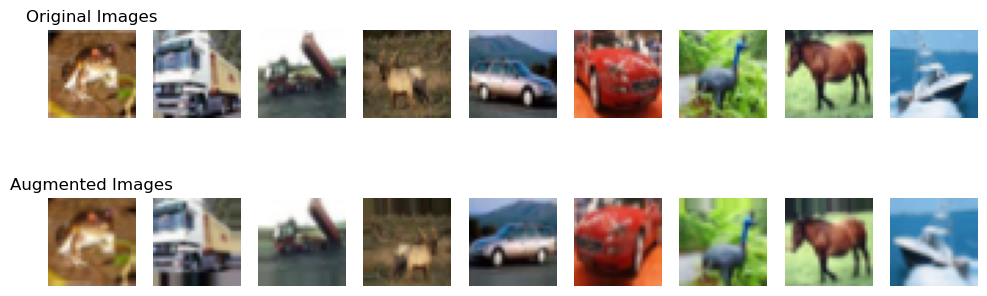

In [6]:
# Generate augmented images
augmented_images = next(datagen.flow(sample_image, batch_size=10, shuffle=False))

# Function to visualize original and augmented images
def visualize_augmentation(original, augmented):
    fig, axes = plt.subplots(2, 9, figsize=(12, 4))
    
    for i in range(9):
        # Original images
        axes[0, i].imshow(original[i])
        axes[0, i].axis("off")
        
        # Augmented images
        axes[1, i].imshow(augmented[i])
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Augmented Images")
    plt.show()

# Visualize the images
visualize_augmentation(sample_image, augmented_images)

In [9]:
augmentation_factor = 1

# Generate augmented images and store them
augmented_images = []
augmented_labels = []


In [10]:
# Generate augmented images in batches (vectorized processing)
batch_size = 1000  # Large batch size for efficiency
num_batches = int(np.ceil(len(x_train) / batch_size))

augmented_images = []
augmented_labels = []

for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(x_train))
    
    batch_images = x_train[start:end]  # Original batch
    batch_labels = y_train[start:end]  # Corresponding labels

    # Generate augmented images
    augmented_batch = np.vstack([
        next(datagen.flow(batch_images, batch_size=len(batch_images), shuffle=False))
        for _ in range(augmentation_factor)
    ])

    # Replicate labels for augmented images
    augmented_labels_batch = np.tile(batch_labels, (augmentation_factor, 1))

    # Store augmented data
    augmented_images.append(augmented_batch)
    augmented_labels.append(augmented_labels_batch)

# Concatenate all augmented data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# Merge original and augmented datasets
x_train_augmented = np.concatenate((x_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

# Shuffle dataset
indices = np.random.permutation(len(x_train_augmented))
x_train_augmented = x_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

print(f"Original training size: {x_train.shape[0]}")
print(f"New training size after augmentation: {x_train_augmented.shape[0]}")

Original training size: 50000
New training size after augmentation: 100000


In [4]:
resnet50_pretrained = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

I0000 00:00:1743944032.052901   54724 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout, Dense

model_output = resnet50_pretrained.output
model_input = resnet50_pretrained.input
model_top = GlobalAveragePooling2D()(model_output)
model_top = Dropout(0.4)(model_top)
out = Dense(10, activation='softmax')(model_top)
Resnet50_model = tf.keras.models.Model(inputs=model_input, outputs=out)

In [7]:
from tensorflow.keras.optimizers import Adam

Resnet50_model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping
import datetime

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
# TensorBoard setup
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)



In [9]:
# Train the model with one-hot encoded labels
history = Resnet50_model.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=10, batch_size=200, callbacks=[tensorboard_callback])



Epoch 1/10


I0000 00:00:1743944157.587838   54822 service.cc:152] XLA service 0x7fb7d8002000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743944157.587923   54822 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-06 12:55:58.915958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743944166.994310   54822 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-06 12:56:13.549754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8928', 3948 bytes spill stores, 3884 bytes spill loads

2025-04-06 12:56:14.063482: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_f

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2544 - loss: 2.1706

2025-04-06 12:57:32.267484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 8 bytes spill stores, 8 bytes spill loads

2025-04-06 12:57:32.326342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 76 bytes spill stores, 76 bytes spill loads

2025-04-06 12:57:32.550096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512', 4 bytes spill stores, 4 bytes spill loads

2025-04-06 12:57:33.770628: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1512_0', 4 bytes spill stores, 4 bytes spill loads

2025-04-06 12:57:33.919748: I external/local

250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 165ms/step - accuracy: 0.2549 - loss: 2.1693 - val_accuracy: 0.4944 - val_loss: 1.8618
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.6097 - loss: 1.2517 - val_accuracy: 0.6968 - val_loss: 1.1029
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.7488 - loss: 0.7715 - val_accuracy: 0.7255 - val_loss: 0.8471
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.8017 - loss: 0.6095 - val_accuracy: 0.4949 - val_loss: 3.7064
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.6878 - loss: 1.0367 - val_accuracy: 0.5871 - val_loss: 2.1918
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.7036 - loss: 0.9553 - val_accuracy: 0.7415 - val_loss: 0.7684
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.8131 - loss: 0.5760 - val_accuracy: 0.6393 - val_loss: 1.1623
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.8209 - loss: 0.5684 - va

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 57166), started 0:00:29 ago. (Use '!kill 57166' to kill it.)

In [14]:

# Evaluate model
test_loss, test_acc = Resnet50_model.evaluate(x_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}")

2025-04-06 13:06:02.203627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1514', 60 bytes spill stores, 60 bytes spill loads

2025-04-06 13:06:04.141752: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1514', 3620 bytes spill stores, 3612 bytes spill loads

2025-04-06 13:06:04.298245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1514', 3828 bytes spill stores, 3804 bytes spill loads



311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7717 - loss: 0.7723

2025-04-06 13:06:23.089109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1514', 3620 bytes spill stores, 3612 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.7717 - loss: 0.7725
Test Accuracy: 0.7696


In [17]:

test_loss, test_acc = Resnet50_model.evaluate(x_test, y_test_one_hot, verbose=2)
print({test_loss, test_acc})

313/313 - 5s - 17ms/step - accuracy: 0.7696 - loss: 0.7935
{0.7935037016868591, 0.769599974155426}


In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


In [23]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
# Get a batch of validation data

# Get predictions
y_pred = Resnet50_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

# Print the classification report
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Accuracy: 0.7696
Precision: 0.7723622137450147
Recall: 0.7696

Classification Report:
               precision    recall  f1-score   support

    airplane       0.74      0.81      0.77      1000
  automobile       0.80      0.90      0.85      1000
        bird       0.81      0.63      0.71      1000
         cat       0.59      0.62      0.60      1000
        deer       0.77      0.75      0.76      1000
         dog       0.71      0.65      0.68      1000
        frog       0.78      0.86      0.82      1000
       horse       0.82      0.83      0.82      1000
        ship       0.91      0.79      0.85      1000
       truck       0.78      0.85      0.82      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



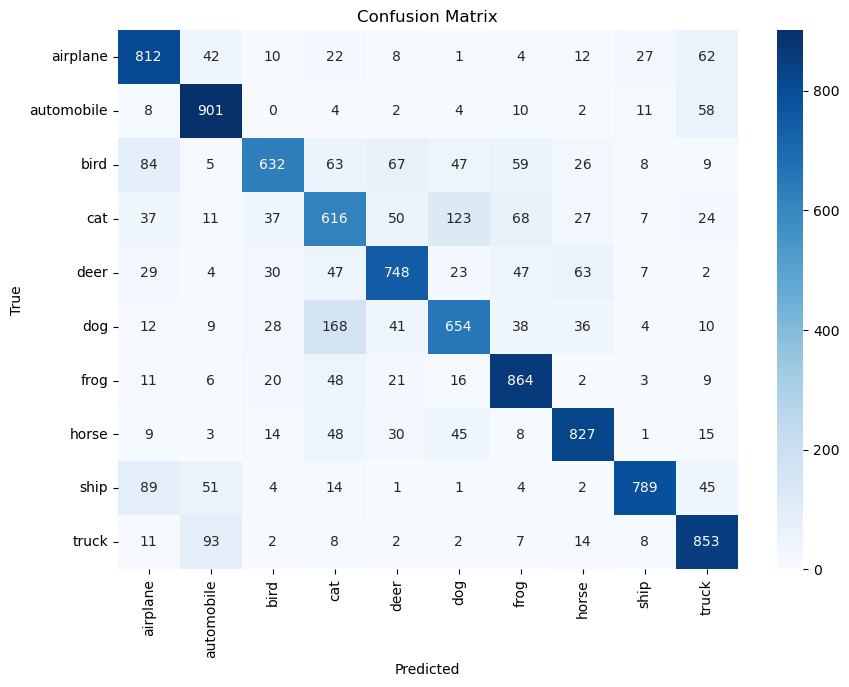

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()